In [1]:
import rioxarray as rx
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os
import scipy.optimize as optimize
os.chdir('/disk/scratch/local.4/harry/TDX/DEM_timeseries')

In [2]:
def CSR(a):
    mean = np.mean(a, axis=0)
    resid = a - mean
    return np.nancumsum(resid,axis=0)

def get_CSR(a):
    return xr.apply_ufunc(CSR, a)

## What about weighting the intensity to avoid bias in middle of timeseries...
def get_weights(a):
    N = a.shape[0]
    T = np.indices(a.shape)[0]
    return T*(1-T/N)

def CSR_weighted(a):
    mean = np.mean(a,axis=0)
    resid = a - mean
    cumsum = np.divide( np.cumsum(resid,axis=0) , get_weights(a) )
    return cumsum#[1:-1]

def get_CSR_weighted(a):
    return xr.apply_ufunc(CSR_weighted, a).isel(t=slice(1,-1))


In [3]:
ds = xr.open_dataset('DEM_timeseries.nc')
UAV = '/exports/csce/datastore/geos/users/s1332488/Chapter3/intensity/UAV_change_1m_masked.tif'
uav = rx.open_rasterio(UAV).sel(band=1).drop('band').rio.reproject('EPSG:4326').rename({'x':'lon','y':'lat'})
uav = uav.where(uav > -100).interp_like(ds).rename('uav')
ds = xr.merge([ds,uav]).sel(lon=slice(-69.73,-69.705),lat=slice(-11.015,-11.035)).isel(t=slice(0,-1))
# Removed final image as it is well past the UAV date and very low HoA
# Remove October 2020 (2 images) as they have an unwrapping artefact
ds = ds.isel(t=[0,1,2,3,4,5,6,6,7,8,10,11,12,13,14,15,18,19,20,21])
#ds = ds.coarsen(lat=3,lon=3,boundary='trim').mean() # Move to 10m approx pixel size?? Not yet!
ds['subtraction'] = ds.height.isel(t=slice(19,22)).mean(dim='t') - ds.height.isel(t=slice(0,3)).mean(dim='t')

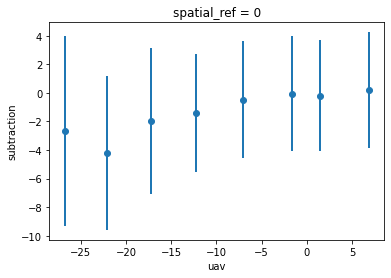

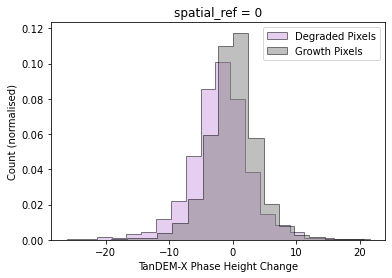

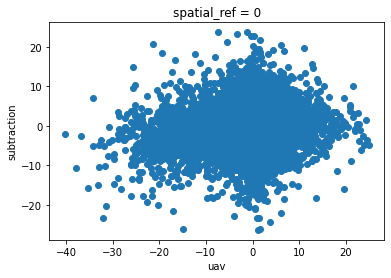

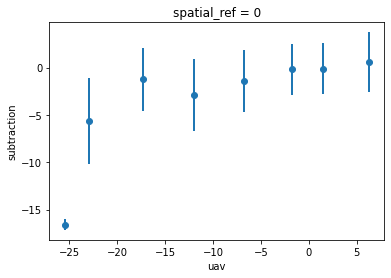

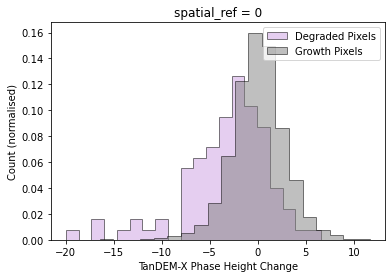

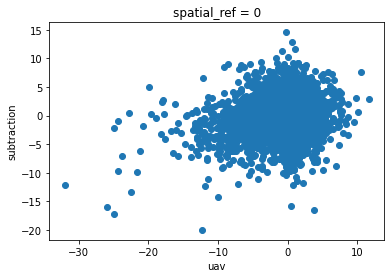

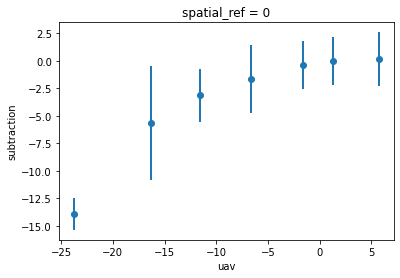

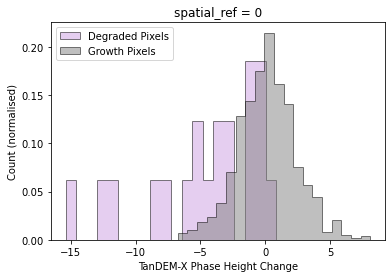

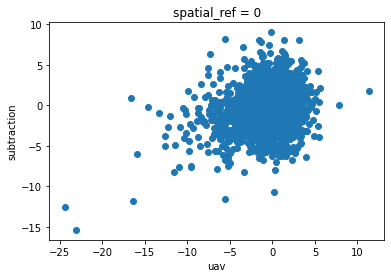

In [103]:
# Simple subtraction: what does it manage?

def subtraction(ds):
    binmean = ds[['uav','subtraction']].groupby_bins('uav',np.arange(-30,15,5)).mean()
    err = ds[['uav','subtraction']].groupby_bins('uav',np.arange(-30,15,5)).std()
    binmean.plot.scatter(x='uav',y='subtraction')
    plt.errorbar(binmean.uav,binmean.subtraction,yerr=err.subtraction,lw=0,elinewidth=2)
    plt.show()

    degraded = ds.subtraction.where(ds.uav < -10)
    degraded.plot.hist(bins=20,density=True,alpha=0.5,
                       histtype = 'stepfilled',facecolor='#cc9fe3',edgecolor='black',label='Degraded Pixels')

    growth = ds.subtraction.where(ds.uav > 1)
    growth.plot.hist(bins=20,alpha=0.5,density=True,
                     histtype='stepfilled',facecolor='grey',edgecolor='black', label='Growth Pixels')
    plt.ylabel('Count (normalised)')
    plt.xlabel('TanDEM-X Phase Height Change')
    plt.legend()
    plt.show()
    
    ds.plot.scatter(x='uav',y='subtraction')
    plt.show()
    
K = 1
subtraction(ds.coarsen(lat=K,lon=K,boundary='trim').mean())
K = 2
subtraction(ds.coarsen(lat=K,lon=K,boundary='trim').mean())
K = 3
subtraction(ds.coarsen(lat=K,lon=K,boundary='trim').mean())

In [4]:
ds['height_csr'] = get_CSR(ds.height).max(dim='t')
ds['coh_csr'] = get_CSR(ds.coherence).max(dim='t')
ds['trend'] = ds.height.polyfit('t',1).sel(degree=1).polyfit_coefficients 
DELTA = ds.t[-1] - ds.t[0]
ds['trend'] = ds.trend * DELTA.astype(np.float64)

height_weighted = get_CSR_weighted(ds.height).max(dim='t')


ds= ds.coarsen(lat=3,lon=3,boundary='trim').mean()


print('Correlations with uav data')
print('Subtraction: ',xr.corr(ds.uav,ds.subtraction).values)
print('Height max CSR: ',xr.corr(ds.uav,ds.height_csr).values)
print('Coherence max CSR: ',xr.corr(ds.uav,ds.coh_csr).values)
print('Weighted height CSR: ',xr.corr(ds.uav,height_weighted).values)
# From this I would suggest that maximum CSR of height is a good way forward

Correlations with uav data
Subtraction:  0.22633870575171322
Height max CSR:  -0.3398959357956767
Coherence max CSR:  -0.12314024696039004
Weighted height CSR:  -0.22165180011399088


/home/s1332488/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


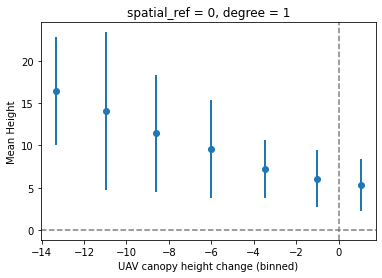

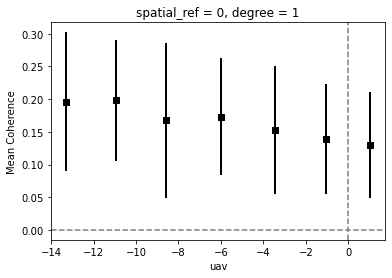

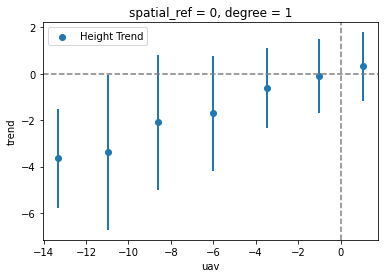

In [200]:
fig = plt.figure()
binned = ds.groupby_bins('uav',np.arange(-15,5,2.5)).mean()
errors = ds.groupby_bins('uav',np.arange(-15,5,2.5)).std()

binned.plot.scatter(x='uav',y='height_csr',label='height (max CSR)')
plt.errorbar(binned.uav,binned.height_csr,yerr=errors.height_csr,lw=0,elinewidth=2)
plt.ylabel('Mean Height')
plt.xlabel('UAV canopy height change (binned)')
plt.axhline(y=0,color='grey',ls='--')
plt.axvline(x=0,color='grey',ls='--')
plt.show()
binned.plot.scatter(x='uav',y='coh_csr',label='coherence (max CSR)',color='black',marker='s')
plt.errorbar(binned.uav,binned.coh_csr,yerr=errors.coh_csr,lw=0,elinewidth=2,color='black')
plt.ylabel('Mean Coherence')
fig.legend(loc=(0.5,0.7))
plt.axhline(y=0,color='grey',ls='--')
plt.axvline(x=0,color='grey',ls='--')
plt.show()

binned.plot.scatter(x='uav',y='trend',label='Height Trend')
plt.errorbar(binned.uav,binned.trend,yerr=errors.trend,lw=0,elinewidth=2)
plt.axhline(y=0,color='grey',ls='--')
plt.axvline(x=0,color='grey',ls='--')
plt.legend()
plt.show()

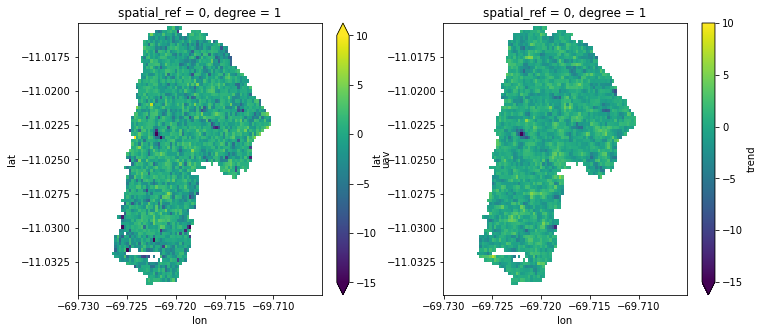

In [207]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
ds.uav.plot(vmin=-15,vmax=10)
plt.subplot(1,2,2)
ds.trend.where(ds.uav>-100).plot(vmin=-15,vmax=10)
plt.savefig('/home/s1332488/Chapter3/Figures/Ph_ts/uav_vs_trend.png')
plt.show()
#ds.height_csr.where(ds.uav>-100).plot(vmin=0,vmax=15)

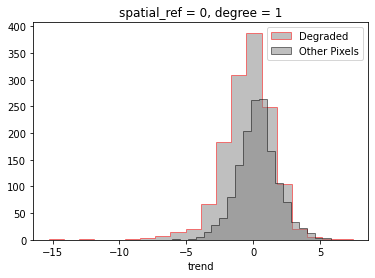

In [182]:
degraded = ds.trend.where(ds.uav < 0)
degraded.plot.hist(bins=20,alpha=0.5,density=False,
                     histtype='stepfilled',facecolor='grey',edgecolor='red', label='Decreases')
other = ds.trend.where(ds.uav >= 0)
other.plot.hist(bins=20,alpha=0.5,density=False,
                     histtype='stepfilled',facecolor='grey',edgecolor='black', label='Increases')
#plt.yscale('log')
plt.legend()

Trend:  0.7697905841815774
CSR:  -0.572142225899702


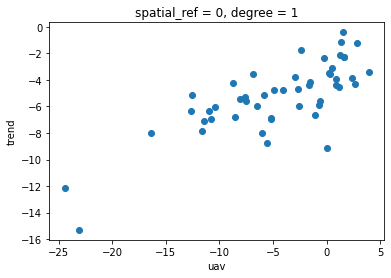

In [155]:
degraded = ds.where(ds.height_csr > 15).where(ds.trend <0)
degraded.plot.scatter(x='uav',y='trend')

print('Trend: ',xr.corr(degraded.uav,degraded.trend).values)
print('CSR: ',xr.corr(degraded.uav,degraded.height_csr).values)

In [176]:
def classifier(HH,TT):
    deg_pred = (ds.height_csr > HH)*(ds.trend < TT).where(ds.uav>-100)
    deg_true = (ds.uav < -10).where(ds.uav>-100)

    N = (deg_pred.isnull()==False).sum()
    true_pos = (deg_pred*deg_true).sum() 
    true_neg = (1-deg_pred* (1-deg_true)).sum()
    false_pos = (deg_pred*(1-deg_true)).sum()
    false_neg = ((1-deg_pred)*deg_true).sum()
    print('DETECTION RATE: ',(true_pos / (true_pos+false_neg)).values)
    print('FALSE ALARM RATE: ',(false_pos / (true_pos+false_pos)).values)
    
classifier(5,-5)
classifier(10,-5)
classifier(15,-5)
classifier(20,-5)


DETECTION RATE:  0.5
FALSE ALARM RATE:  0.6666666666666666
DETECTION RATE:  0.5
FALSE ALARM RATE:  0.6666666666666666
DETECTION RATE:  0.5
FALSE ALARM RATE:  0.6
DETECTION RATE:  0.4
FALSE ALARM RATE:  0.5555555555555556


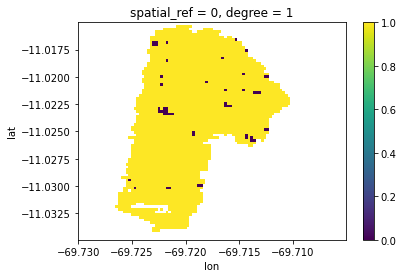

In [165]:
(deg_pred).plot()

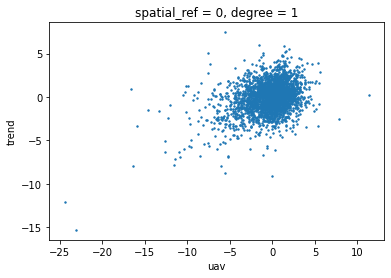

In [136]:
ds.plot.scatter(x='uav',y='trend',s=2)

In [74]:
ds.trend.rename({'lat':'y','lon':'x'}).rio.to_raster('/exports/csce/datastore/geos/users/s1332488/Chapter3/DEM/trend.tif')

In [113]:
cutoff_h = ds.height_csr.where(ds.uav >0).mean()
cutoff_coh = ds.coh_csr.where(ds.uav>0).mean()

ds['height_csr_flt'] = (ds.height_csr - cutoff_h) * (ds.height_csr > cutoff_h)
ds['coh_csr_flt'] = (ds.coh_csr - cutoff_coh) * (ds.coh_csr > cutoff_coh)

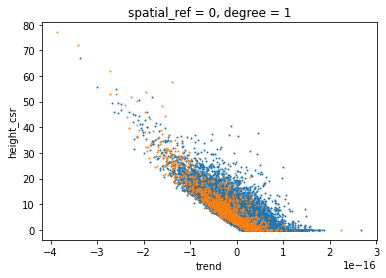

In [191]:
ds.where(ds.uav>-10).plot.scatter(x='trend',y='height_csr',s=1)
ds.where(ds.uav<-10).plot.scatter(x='trend',y='height_csr',s=1)

[-0.07498582  0.49927849  0.04274102]
CORR 0.4750546034444345


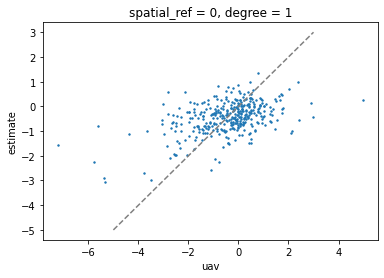

In [5]:
COARSENING = 3

coarse = ds.coarsen(lat=COARSENING,lon=COARSENING,boundary='trim').mean()

def model(p):
    height = p[0]*coarse.height_csr
    #coh = p[1]*coarse.coh_csr
    tr = p[1]*coarse.trend
    return height+tr+p[2]#height + coh + trendp[3]

def cost_fn(p):
    estimate = model(p)
    rmsq = np.sqrt( ((estimate-coarse.uav)**2).sum() )
    return rmsq

p = optimize.minimize(cost_fn,[-1,-1,1]).x

coarse['estimate'] = model(p)
coarse.plot.scatter(x='uav',y='estimate',s=2)
plt.plot([-5,3],[-5,3],color='grey',ls='--')

plt.savefig('/home/s1332488/Chapter3/Figures/Ph_ts/Ph_model.png')
print(p)
print('CORR',xr.corr(coarse.uav,coarse.estimate).values)

In [6]:
metres = ds.uav.rename({'lat':'y','lon':'x'}).rio.reproject('EPSG:5839')
print(metres.x.values[1]-metres.x.values[0])
print(metres.y.values[1]-metres.y.values[0])

27.172164745396003
-27.172164745628834


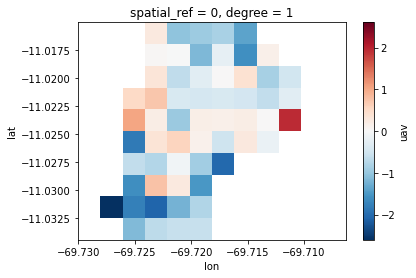

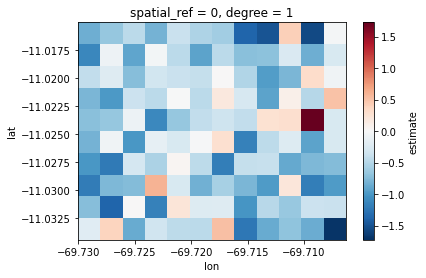

In [218]:
coarse.uav.plot()
plt.show()
coarse.estimate.plot()